## Description

In this notebook, we compare the masserstein proportions with the monoisotopic peak intensities.

## Data & modules

In [15]:
%matplotlib notebook

In [16]:
from masserstein import Spectrum
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from time import time
import pandas as pd
from additional_functions import profile_ion_image, centroided_ion_image

In [17]:
import numpy.random as rd

In [18]:
analyzed_mass_range = (600, 1000)

In [19]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [20]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [21]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

In [22]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [23]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 207 formulas for cerebellum
Loaded 180 formulas for bladder


In [24]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

In [25]:
lipid_masses = {n: [s.confs[0][0] for s in lipid_spectra[n]] for n in image_names}

Load the quantification results from Notebook 5:

In [26]:
masserstein_estimation = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
[masserstein_estimation[n].shape for n in image_names]

[(21, 81, 207), (134, 260, 180)]

In [27]:
single_peak_intensities = {n : np.load(n+'_single_peak_images.dmp', allow_pickle=True) for n in image_names}
[single_peak_intensities[n].shape for n in image_names]

[(21, 81, 207), (134, 260, 180)]

<IPython.core.display.Javascript object>


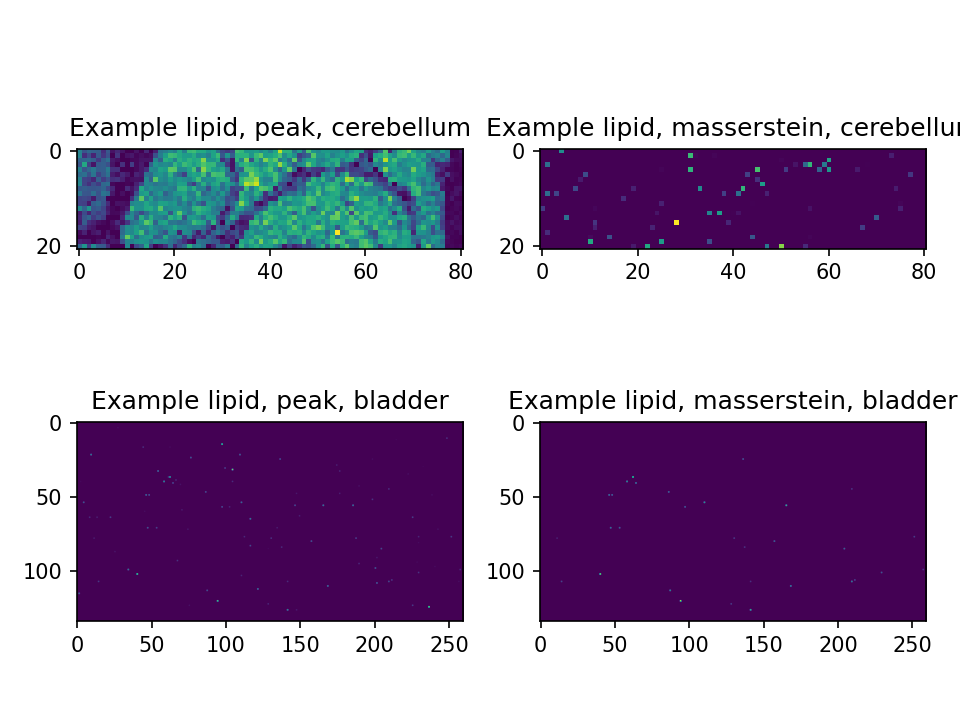

In [28]:
lipid_id = 34

plt.figure()
plt.subplot(221)
plt.title('Example lipid, peak, cerebellum')
plt.imshow(single_peak_intensities['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Example lipid, masserstein, cerebellum')
plt.imshow(masserstein_estimation['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Example lipid, peak, bladder')
plt.imshow(single_peak_intensities['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Example lipid, masserstein, bladder')
plt.imshow(masserstein_estimation['bladder'][...,lipid_id])
plt.tight_layout()
plt.show()

## Comparing the estimated spatial distributions

In [29]:
for n in image_names:
    print(n)
    print(sorted([s.confs[0][0] for s in lipid_spectra[n]]))

cerebellum
[700.28641961624, 700.359190634, 701.30682070885, 701.37959172661, 702.3748406985401, 703.28608526451, 703.39524179115, 704.39049076308, 705.44727736457, 711.43671267983, 712.5047326695201, 713.45236274437, 713.4887482532499, 714.41122620742, 715.46801280891, 716.42687627196, 716.46326178084, 722.48908260498, 725.4887482532499, 725.49998164145, 726.3748406985401, 727.46801280891, 727.51563170599, 728.42687627196, 732.4217908921601, 737.45236274437, 739.46801280891, 741.4836628734499, 741.49489626165, 741.53128177053, 742.40614082762, 742.4425263365, 742.47891184538, 743.46292742911, 743.49931293799, 743.5469318350699, 744.45817640104, 744.49456190992, 745.4785774936499, 753.4836628734499, 753.53128177053, 754.40614082762, 755.46292742911, 755.5469318350699, 757.55134851141, 758.5102119744599, 760.45309102124, 761.45236274437, 762.48399722518, 763.46801280891, 764.5360327986, 765.4836628734499, 766.5516828631401, 767.49931293799, 767.5469318350699, 768.47343254044, 768.567332

In [30]:
signal_correlations = {n: np.zeros(len(lipid_spectra[n])) for n in image_names}
for n in image_names:
    for i in range(len(lipid_spectra[n])):
        peak = single_peak_intensities[n][...,i]
        prop = masserstein_estimation[n][...,i]
        peak = peak - np.mean(peak)
        peak = peak / np.std(peak)
        prop = prop - np.mean(prop)
        prop = prop / np.std(prop)
        signal_correlations[n][i] = np.mean(peak*prop)

<IPython.core.display.Javascript object>


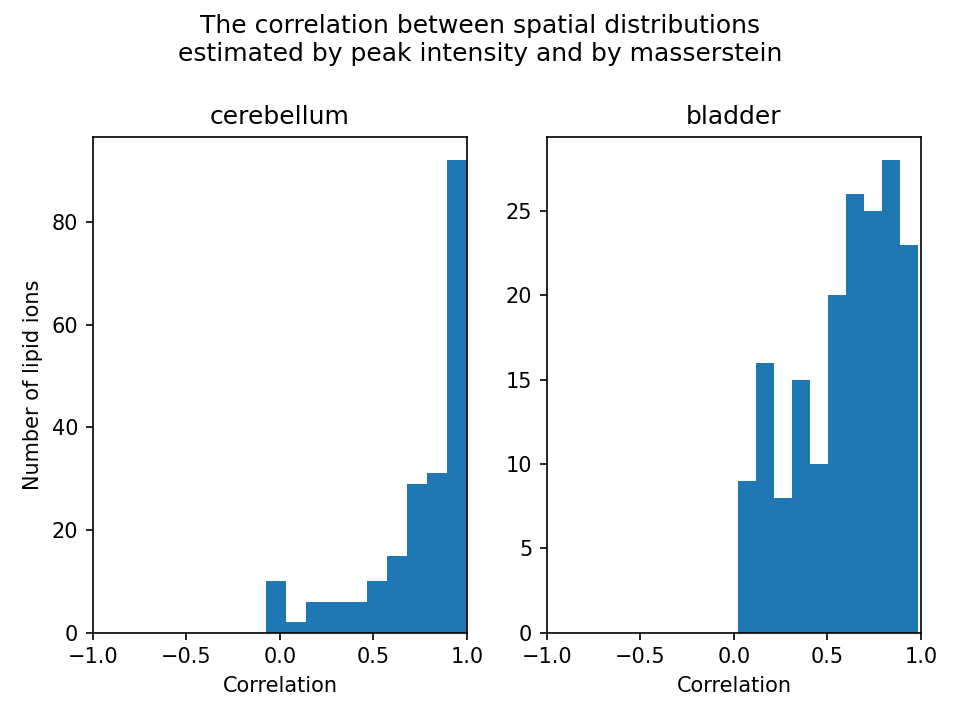

In [37]:
plt.figure()
plt.suptitle('The correlation between spatial distributions\nestimated by peak intensity and by masserstein')
plt.subplot(121)
plt.title(image_names[0])
plt.hist(signal_correlations[image_names[0]])
plt.xlabel('Correlation')
plt.ylabel('Number of lipid ions')
plt.xlim(-1, 1)
plt.subplot(122)
plt.title(image_names[1])
plt.hist(signal_correlations[image_names[1]])
plt.xlabel('Correlation')
plt.xlim(-1, 1)
plt.tight_layout()
plt.show() 

Showing three lowest-correlation lipids per image:

<IPython.core.display.Javascript object>


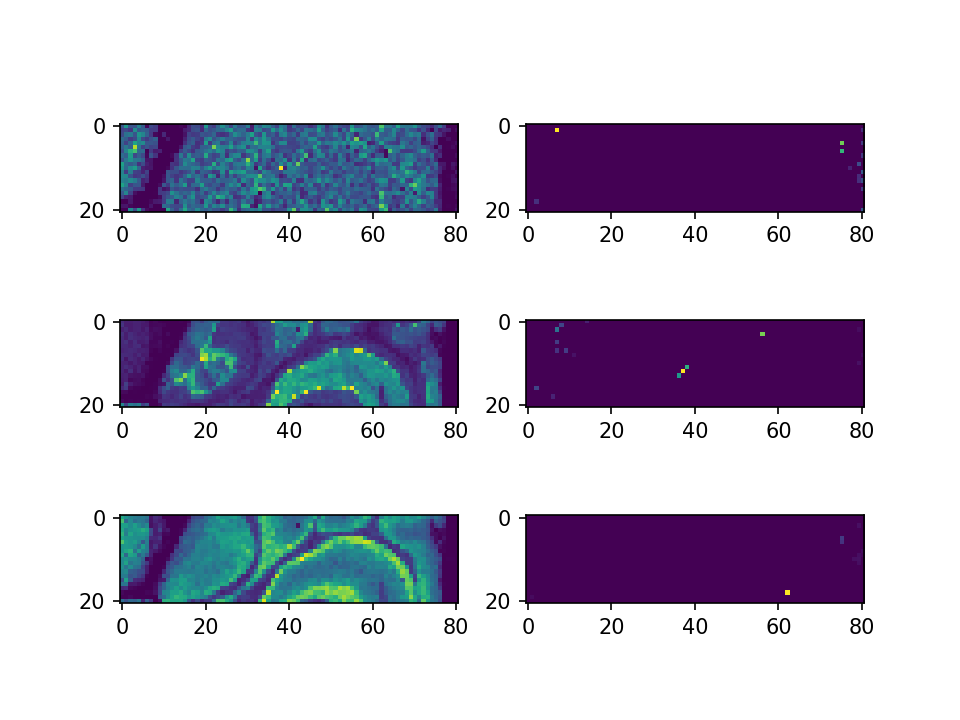

In [32]:
plt.figure()
for i, lid in enumerate(np.argsort(signal_correlations['cerebellum'])[:3]):
    plt.subplot(321+2*i)
    plt.imshow(single_peak_intensities['cerebellum'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['cerebellum'][...,lid])

<IPython.core.display.Javascript object>


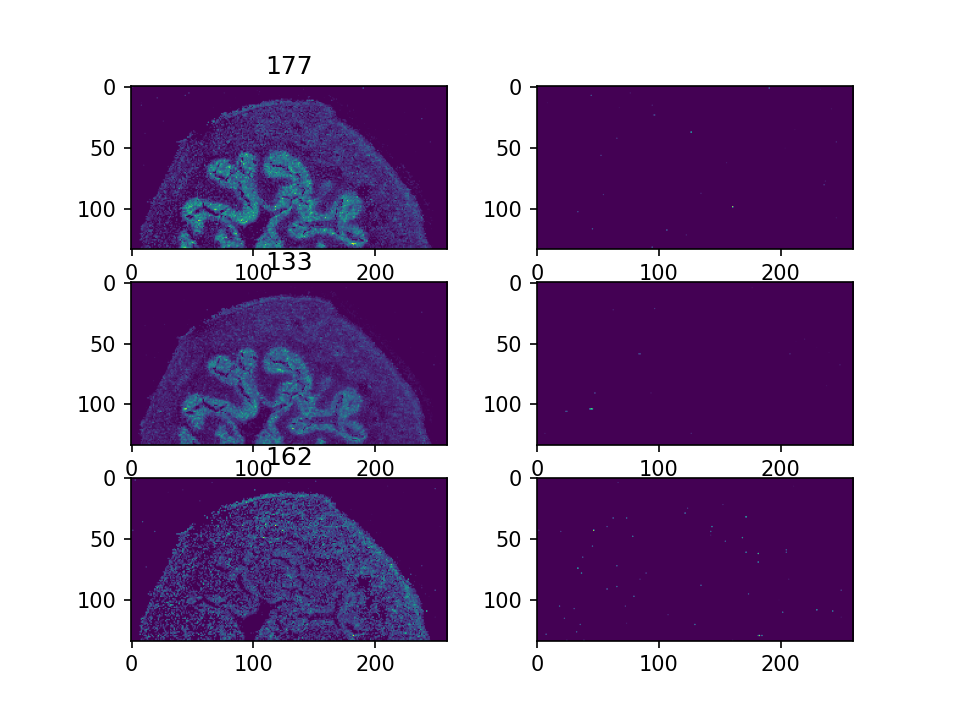

In [33]:
plt.figure()
for i, lid in enumerate(np.argsort(signal_correlations['bladder'])[:3]):
    plt.subplot(321+2*i)
    plt.title(lid)
    plt.imshow(single_peak_intensities['bladder'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['bladder'][...,lid])

Summarize the correlations

In [35]:
print('Number of highly correlated lipids, rho>=0.8:')
for n in image_names:
    print(n, np.sum(signal_correlations[n] >= 0.8))
    
print('Number of moderately correlated lipids, 0.6<=rho<0.8:')
for n in image_names:
    print(n, np.sum((signal_correlations[n] >= 0.6)*(signal_correlations[n] < 0.8)))

print('Number of highly distorted lipids, rho<0.6:')
for n in image_names:
    print(n, np.sum(signal_correlations[n] < 0.6))


Number of highly correlated lipids, rho>=0.8:
cerebellum 115
bladder 46
Number of moderately correlated lipids, 0.6<=rho<0.8:
cerebellum 48
bladder 56
Number of highly distorted lipids, rho<0.6:
cerebellum 44
bladder 78


Examples of moderately correlated lipids

<IPython.core.display.Javascript object>


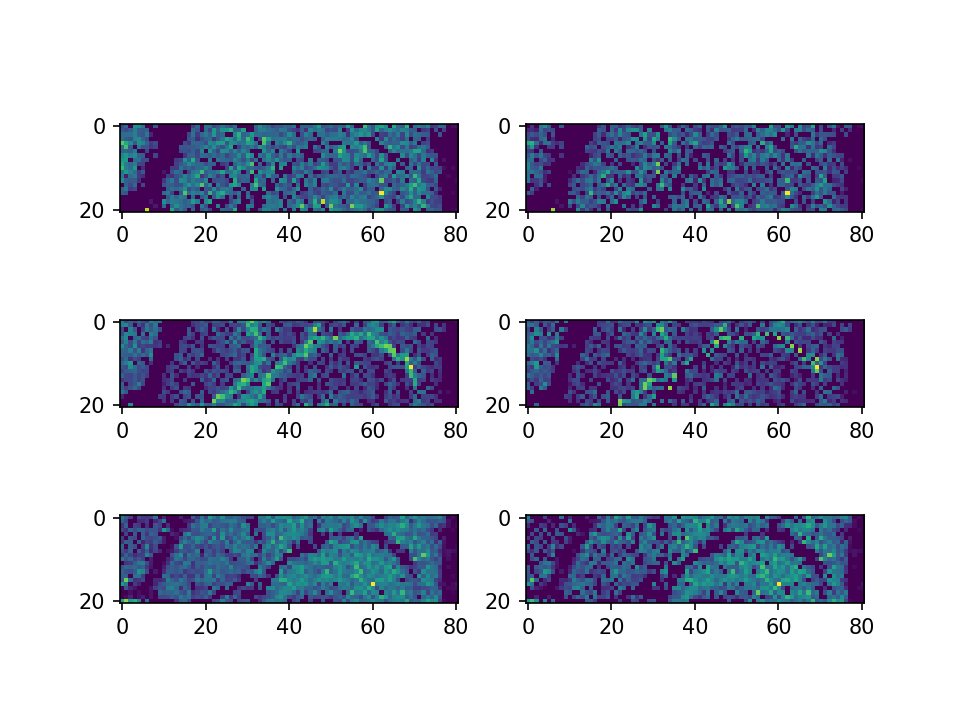

In [43]:
plt.figure()
for i, lid in enumerate(np.where((signal_correlations['cerebellum'] >= 0.6)*(signal_correlations['cerebellum'] < 0.9))[0][:3]):
    plt.subplot(321+2*i)
    plt.imshow(single_peak_intensities['cerebellum'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['cerebellum'][...,lid])

<IPython.core.display.Javascript object>


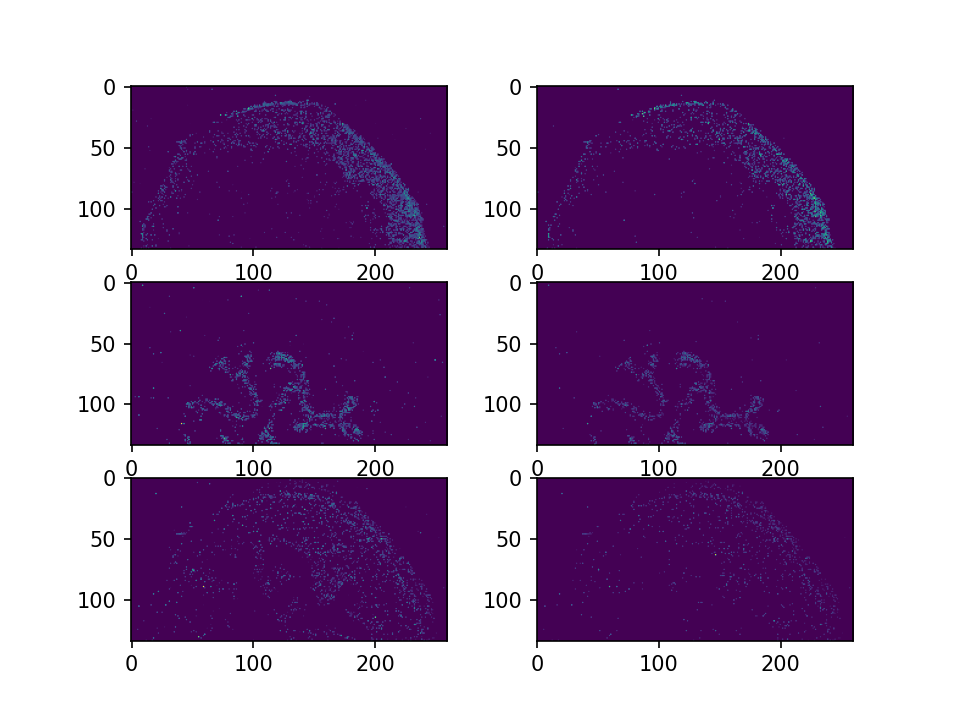

In [44]:
plt.figure()
for i, lid in enumerate(np.where((signal_correlations['bladder'] >= 0.6)*(signal_correlations['bladder'] < 0.9))[0][:3]):
    plt.subplot(321+2*i)
    plt.imshow(single_peak_intensities['bladder'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['bladder'][...,lid])

Remnant:

<IPython.core.display.Javascript object>


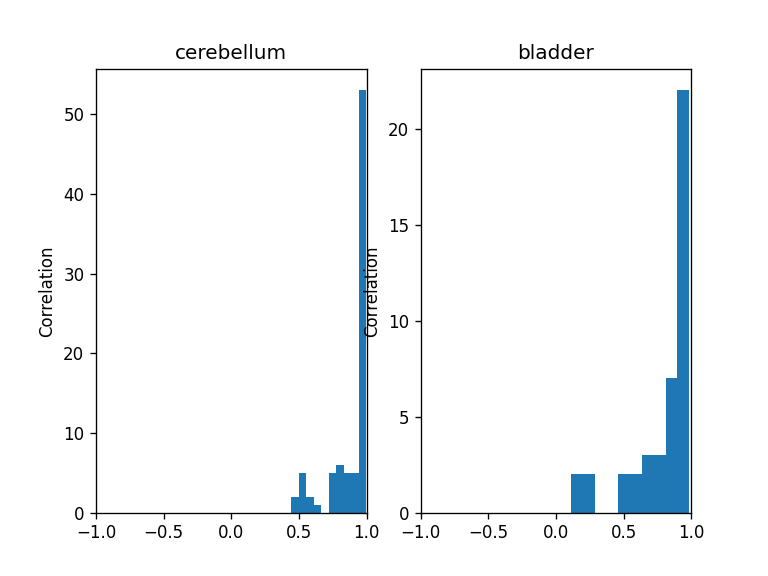

In [17]:
# plt.figure()
# plt.subplot(121)
# plt.title(image_names[0])
# plt.hist(signal_correlations[image_names[0]])
# plt.ylabel('Correlation')
# plt.xlim(-1, 1)
# plt.subplot(122)
# plt.title(image_names[1])
# plt.hist(signal_correlations[image_names[1]])
# plt.ylabel('Correlation')
# plt.xlim(-1, 1)
# plt.show() 

We had a bunch of lipids around 0.5 in cerebellum